In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from curvefit.core.model import CurveModel
from curvefit.core.functions import ln_gaussian_cdf, gaussian_cdf
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from copy import deepcopy
import pdb
import matplotlib as mpl

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

In [53]:
# Fetches the data from the COVID19India website
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # NOTE : start date of this data is 30 Jan
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])

In [54]:
class GaussianCDF:
    """Fit a single Gaussian Atom to cumulative daily deaths"""
    
    def __init__(self, social_distance=None):
        self.model = None
        self.social_distance = social_distance
        self.num_params = 3
    
    def fit(self, daily_deaths, fe_init=None):
        daily_deaths = np.array(daily_deaths)
        n_data = daily_deaths.shape[0]
        
        # Prepare the data frame
        df = pd.DataFrame()
        df['death_rate'] = np.cumsum(daily_deaths)
        df['time'] = np.arange(df['death_rate'].shape[0])
        df['ln_death_rate'] = np.log(df['death_rate'] + 1) # Add 1 to pad in case the #deaths are zero
        df['group'] = ['all'] * n_data
        df['cov_one'] = [1.0] * n_data 
        
        
        if self.social_distance is not None:
            df['social_distance'] = self.social_distance 
            col_covs = [['cov_one', 'social_distance']] * 3
            num_fe = 6
            fe_init = [-3, 0, 100, 0, 10, 0] if fe_init is None else fe_init
        else:
            col_covs = [['cov_one']] * 3
            num_fe = 3
            fe_init = [-3, 100, 1] if fe_init is None else fe_init
        
        # Set up the CurveModel
        self.model = CurveModel(
            df=df,
            col_t='time',
            col_obs='ln_death_rate',
            col_group='group',
            col_covs=col_covs,
            param_names=['alpha', 'beta', 'p'],
            link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
            var_link_fun=[lambda x: x] * num_fe,
            fun=ln_gaussian_cdf
        )
        
        
        # Fit the model to estimate parameters
        self.model.fit_params(
            fe_init=fe_init,
            options={
                'ftol': 1e-14,
                'maxiter': 500
            },
            re_bounds= [[0, 0]] * num_fe    # No random effects
        )
        
    
    def predict(self, t):
        """Get predictions for values in t"""
        
        return self.model.predict(t=t, group_name='all')
    
    def get_params(self):
        return np.squeeze(self.model.params)
    
    def predict_covar(self, t):
        """Get predictions taking into account social distancing covariates"""
        
        # Prepare the list of parameters to be fed into the ln_gaussian_cdf function
        params = self.model.expanded_params
        
        if len(t) > self.social_distance.shape[0]:
            # For prediction into the future use the aggregated parameters 
            
            future_days = len(t) - self.social_distance.shape[0]
            
            for i in range(future_days):
                params = np.append(params, self.model.params, axis=1)
        else:
            params = params[:len(t)]
            
        return ln_gaussian_cdf(t, params)

In [55]:
class MultiGaussianCDF:
    """Mixture of Gaussians with staggered peaks"""
    
    def __init__(self, params, k=6, inc=2):
        self.params = params
        self.k = k
        self.inc = inc
        self.weights = None
        
    def compute_x(self, ln_death_rate):
        X = np.zeros((ln_death_rate.shape[0], 2 * self.k + 1))
        self.params[2] -= self.inc * self.k
        
        t = np.arange(ln_death_rate.shape[0])
        
        for j in range(2 * self.k + 1):
            X[:, j] = ln_gaussian_cdf(t, params)
            params[2] += self.inc
            
        return X
        
    def fit(self, ln_death_rate):
        X = self.compute_x(ln_death_rate)
        y = ln_death_rate
        
        reg = LinearRegression(fit_intercept=False)
        reg.fit(X, y)
        self.weights = reg.coef_
        
    def predict(self, t):
        X = self.compute_x(t)
        return X @ self.weights

<h2>Fitting a model for cumulative number of deaths in India</h2>

Description - the model is a generalized fixed effects model. Since there is only one location (for now) the link functions are simple and random effects are neglected. Further, social distancing covariates are ignored as a first approximation. 

$$f(t; \alpha, \beta, p) =
        \frac{p}{2} \left( 1 + \frac{2}{\pi} \int_0^{\alpha ( t - \beta )}
            \exp( - \tau^2 ) d \tau \right)$$
            
Here, $f$ is the cumulative number of deaths and $\alpha, \beta, p$ are parameters with the following link functions

\begin{aligned}
    \alpha & = \exp( a ) \\
    \beta  & =  b \\
    p      & = \exp( \phi  )
\end{aligned}

where $a, b, \phi$ are fixed effects learnt by the model. This amounts to fitting a Gaussian on the daily death data.

<h3>Single Gaussian Atom</h3>

In [56]:
fetcher = DataFetcher()
fetcher.fetch()

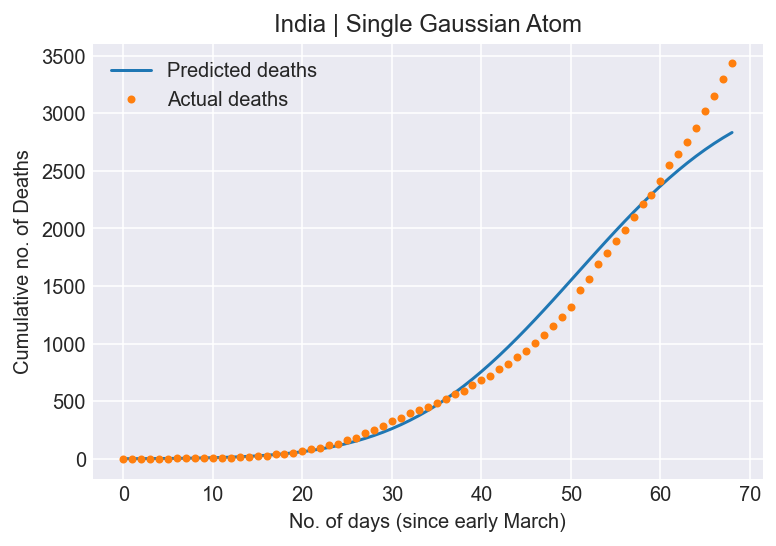

In [57]:
# Fit and plot data
offset = 43 # Start reading data from 14th March
death_data = fetcher.cases_time_series['dailydeceased'][offset:]
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF()
model_india.fit(death_data)
pred = model_india.predict(time_values)

plt.plot(time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.title("India | Single Gaussian Atom")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative no. of Deaths")
plt.legend()
plt.show()

<h3>13 Gaussian Atoms with staggered peaks</h3>

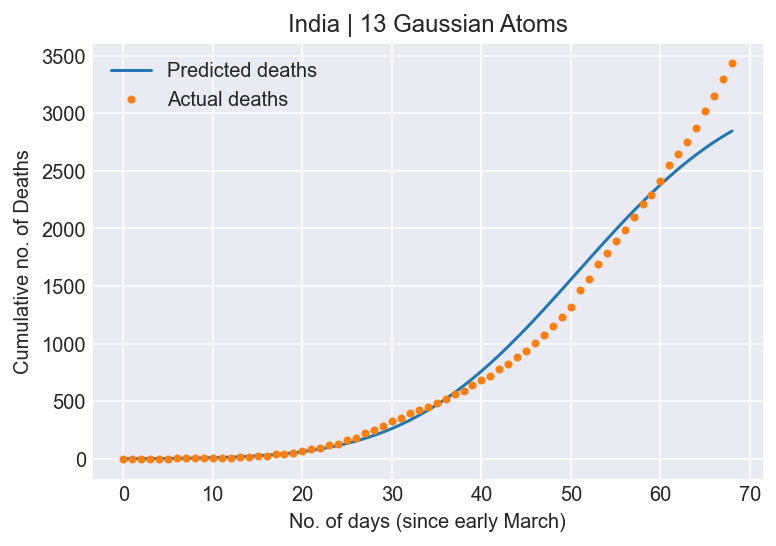

In [58]:
# Fit and plot data
params = model_india.get_params()
multi_gauss = MultiGaussianCDF(params)
ln_death_rate = np.log(np.cumsum(death_data) + 1)
multi_gauss.fit(ln_death_rate)

preds = multi_gauss.predict(np.arange(ln_death_rate.shape[0]))
plt.plot(np.exp(preds), label="Predicted deaths")
plt.plot(np.cumsum(death_data), '.', label="Actual deaths")
plt.title("India | 13 Gaussian Atoms")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative no. of Deaths")
plt.legend()
plt.show()

<h2>Fitting a model for cumulative number of deaths in MH</h2>

In [59]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased': [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])
                
    def start_date(self):
        return self.raw_data['states_daily'][0]['date']

<h2>Single Gaussian Atom</h2>

In [60]:
fetcher = DataFetcherState()
fetcher.fetch()

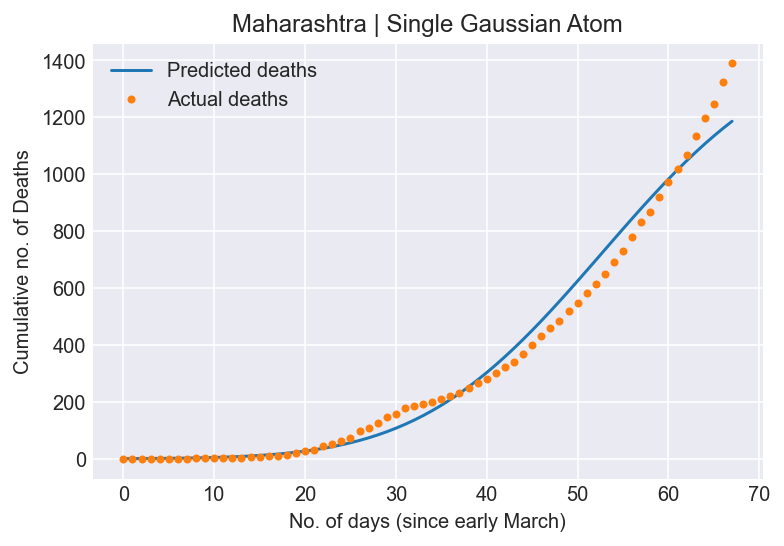

In [61]:
# Fit and plot data
death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)
time_values = np.arange(death_data.shape[0])

model_mh = GaussianCDF()
model_mh.fit(death_data)
pred = model_mh.predict(time_values)

plt.plot(time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.title("Maharashtra | Single Gaussian Atom")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative no. of Deaths")
plt.legend()
plt.show()

<h2>Multiple Gaussian Atoms</h2>

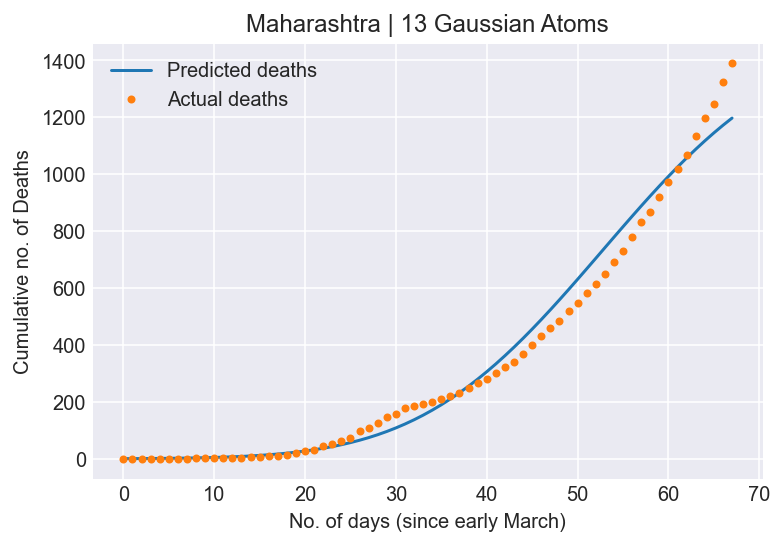

In [62]:
# Fit and plot data
params = model_mh.get_params()
multi_gauss = MultiGaussianCDF(params)
ln_death_rate = np.log(np.cumsum(death_data) + 1)
multi_gauss.fit(ln_death_rate)

preds = multi_gauss.predict(np.arange(ln_death_rate.shape[0]))
plt.plot(np.exp(preds), label="Predicted deaths")
plt.plot(np.cumsum(death_data), '.', label="Actual deaths")
plt.title("Maharashtra | 13 Gaussian Atoms")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative no. of Deaths")
plt.legend()
plt.show()

<h1>Testing predictive power</h1>

Here the model is fit on a subset of the death data. This will then be used extrapolate deaths. The extrapolated deaths can be compared with the actual number of deaths to determine how well the model can predict values. 

<h2>India - single gaussian atom</h2>

In [63]:
fetcher = DataFetcher()
fetcher.fetch()

/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


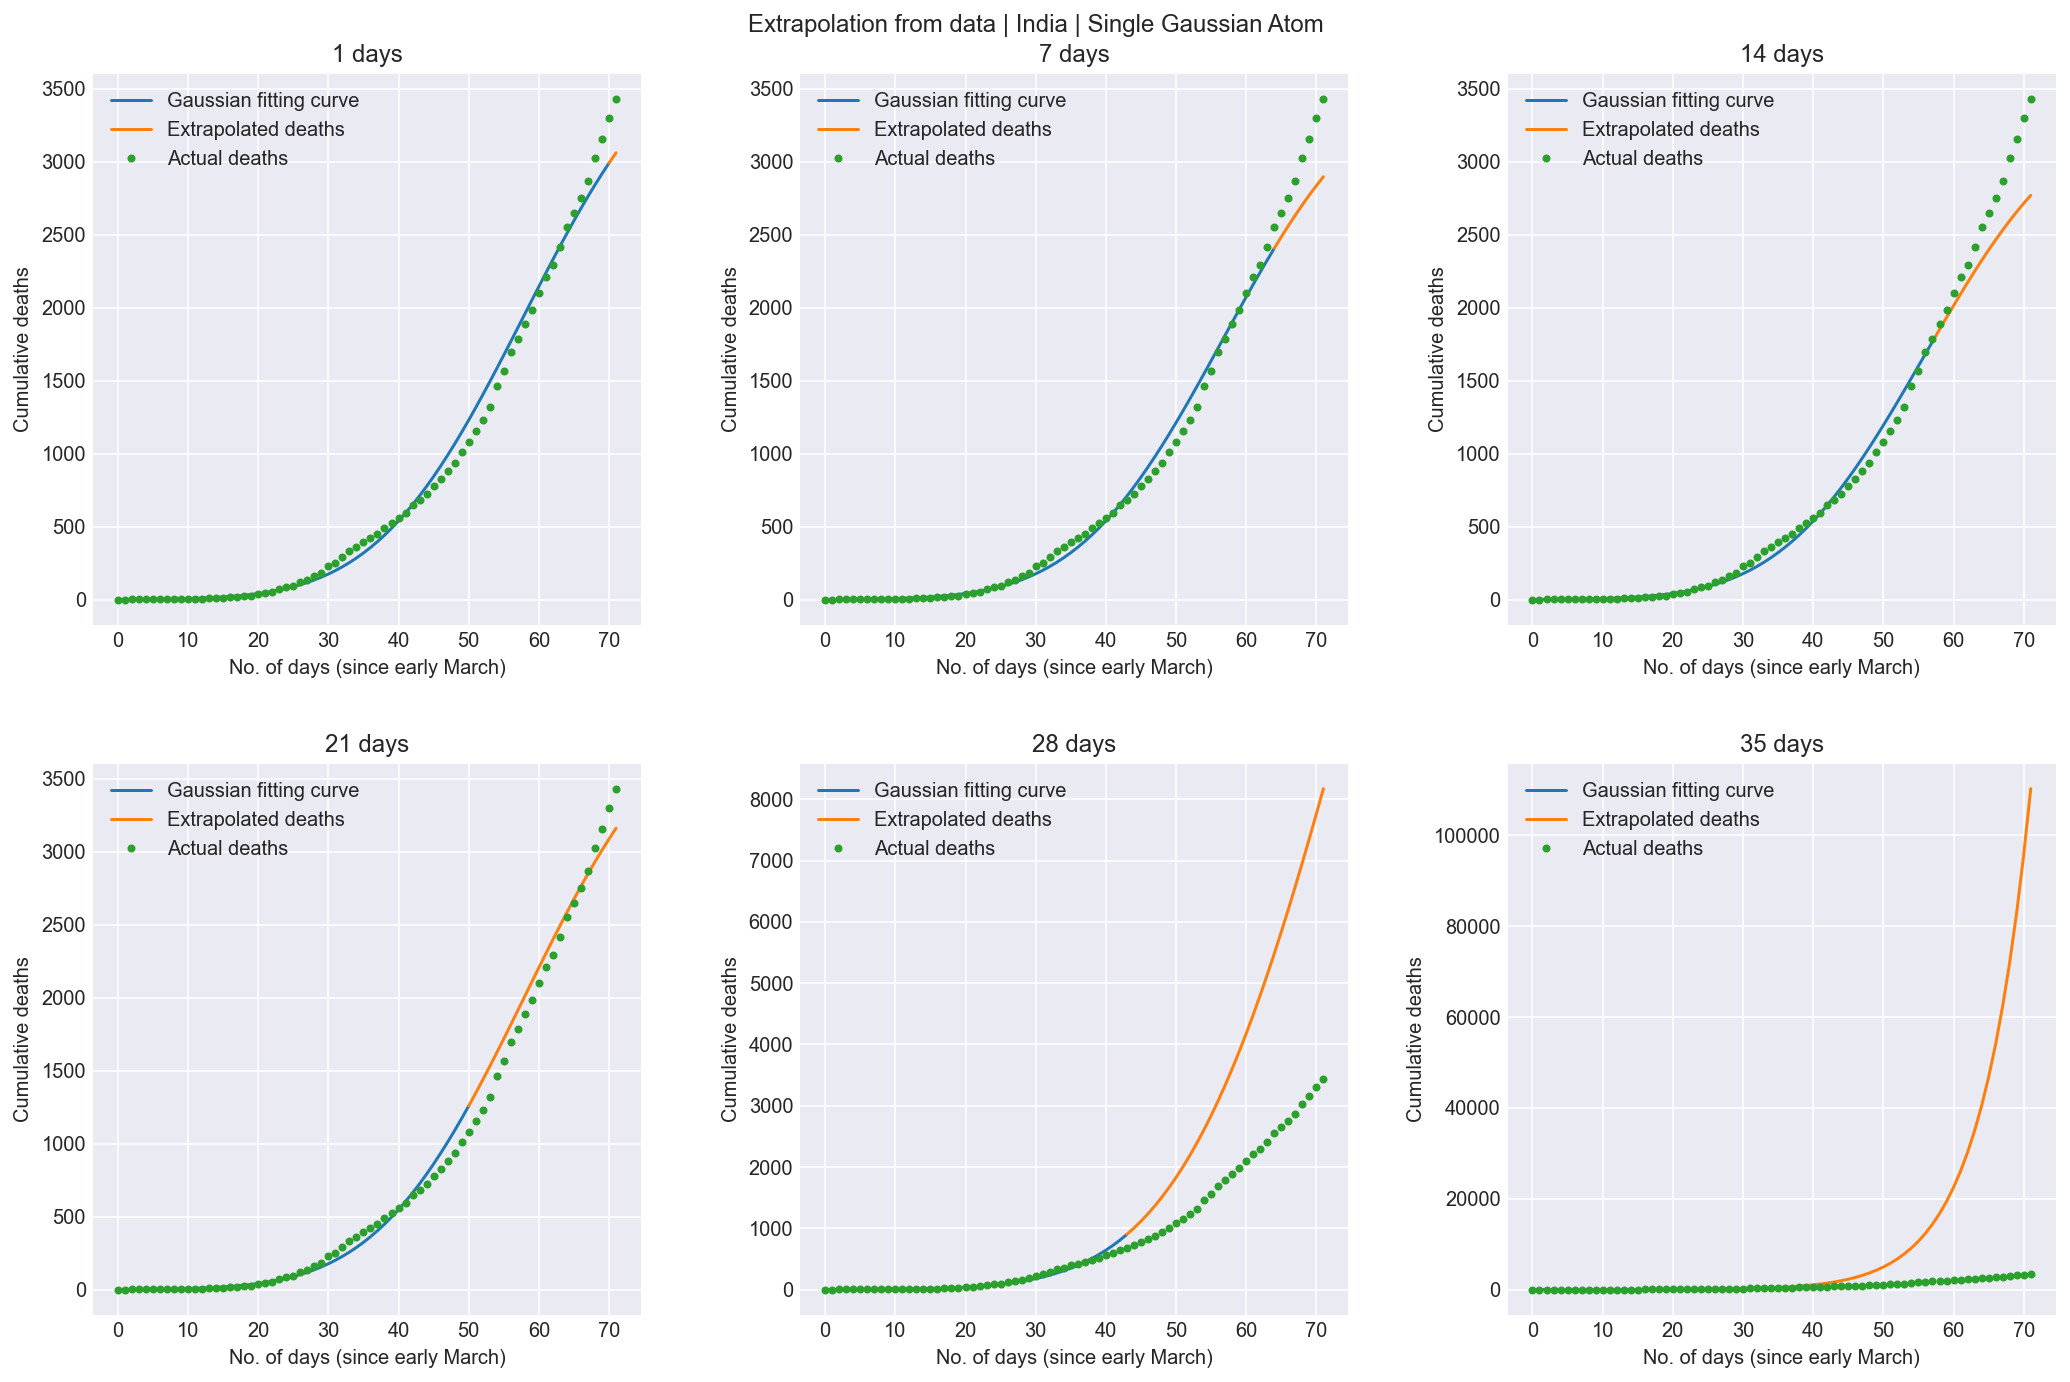

In [64]:
# Plot data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

for limit, ax in zip([1, 7, 14, 21, 28, 35], axs.flat):
    death_data = fetcher.cases_time_series['dailydeceased'][offset:]
    time_values = np.arange(death_data.shape[0])

    model_india = GaussianCDF()
    model_india.fit(death_data[:-limit])
    pred = model_india.predict(time_values)

    ax.plot(time_values[:-limit], np.exp(pred)[:-limit], label="Gaussian fitting curve")
    ax.plot(time_values[-limit-1:], np.exp(pred)[-limit-1:], label="Extrapolated deaths")
    ax.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
    ax.set_title("{} days".format(limit))
    ax.set_xlabel("No. of days (since early March)")
    ax.set_ylabel("Cumulative deaths")
    ax.legend()
    
fig.suptitle("Extrapolation from data | India | Single Gaussian Atom")
fig.tight_layout(pad=3.0)
fig.show()

<h2>MH - single gaussian atom</h2>

In [65]:
fetcher = DataFetcherState()
fetcher.fetch()

/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


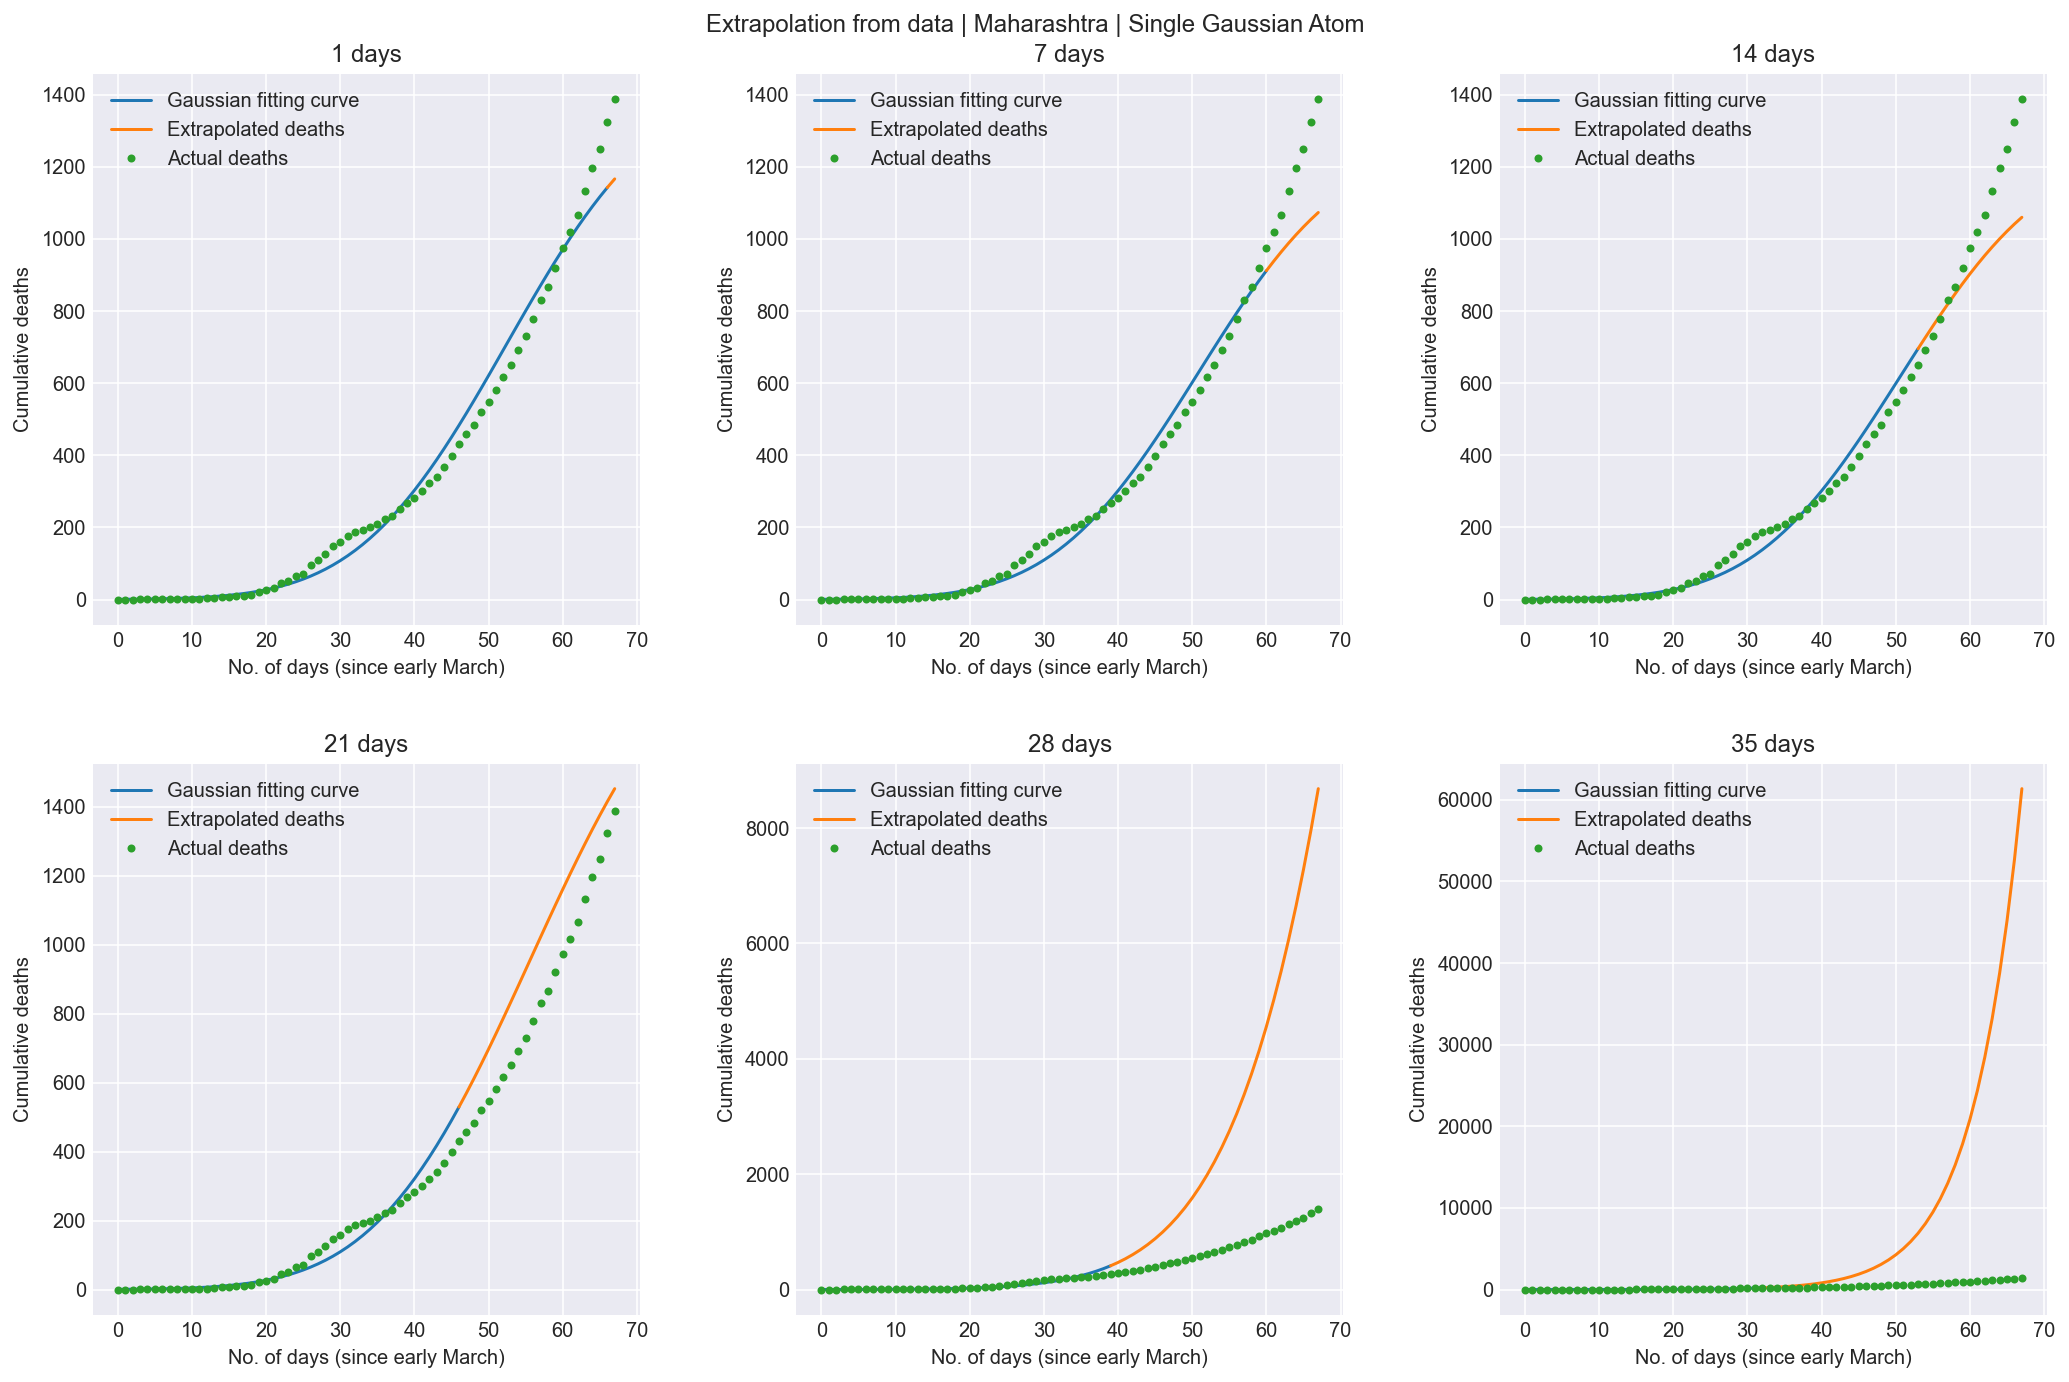

In [66]:
# Plot data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for limit, ax in zip([1, 7, 14, 21, 28, 35], axs.flat):
    death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)
    time_values = np.arange(death_data.shape[0], dtype=float)

    model_india = GaussianCDF()
    model_india.fit(death_data[:-limit])
    pred = model_india.predict(time_values)

    ax.plot(time_values[:-limit], np.exp(pred)[:-limit], label="Gaussian fitting curve")
    ax.plot(time_values[-limit-1:], np.exp(pred)[-limit-1:], label="Extrapolated deaths")
    ax.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
    ax.set_title("{} days".format(limit))
    ax.set_xlabel("No. of days (since early March)")
    ax.set_ylabel("Cumulative deaths")
    ax.legend()
    
fig.suptitle("Extrapolation from data | Maharashtra | Single Gaussian Atom")
fig.tight_layout(pad=3.0)
fig.show()

<h1>Peak prediction</h1>

<h2>India - single gaussian atom</h2>

In [67]:
fetcher = DataFetcher()
fetcher.fetch()

In [68]:
offset = 43 # Exclude data from the starting
extra_pred = 60 # How much to predict into the future

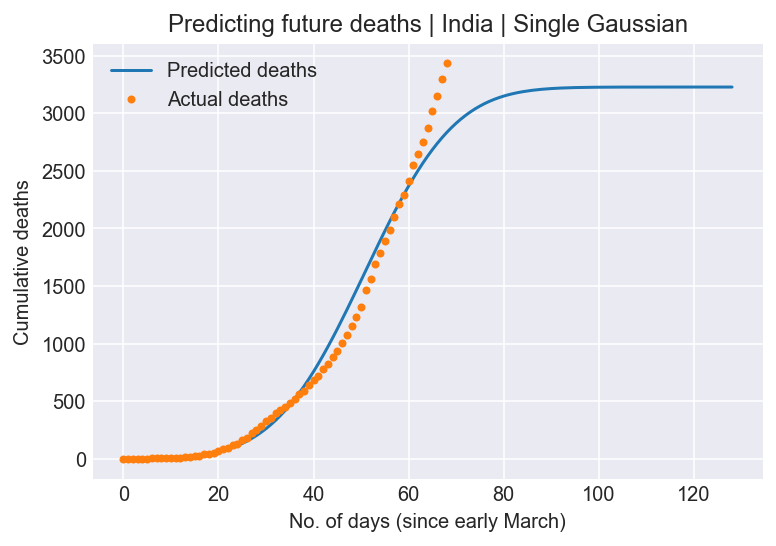

In [69]:
# Fit and plot data
death_data = fetcher.cases_time_series['dailydeceased'][offset:]
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF()
model_india.fit(death_data)
future_time_values = np.arange(death_data.shape[0] + extra_pred)
pred = model_india.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | India | Single Gaussian")
plt.show()

<h2>India - multiple gaussian atoms</h2>

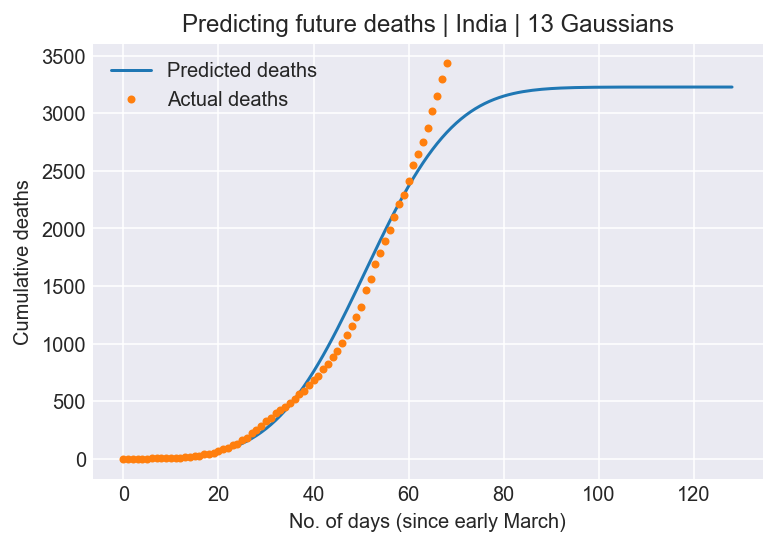

In [70]:
# Fit and plot data
params = model_india.get_params()
multi_gauss = MultiGaussianCDF(params)
ln_death_rate = np.log(np.cumsum(death_data) + 1)
multi_gauss.fit(ln_death_rate)

preds = multi_gauss.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | India | 13 Gaussians")
plt.show()

<h2>MH - single gaussian atom</h2>

In [71]:
fetcher = DataFetcherState()
fetcher.fetch()

In [72]:
extra_pred = 60 # How much to predict into the future

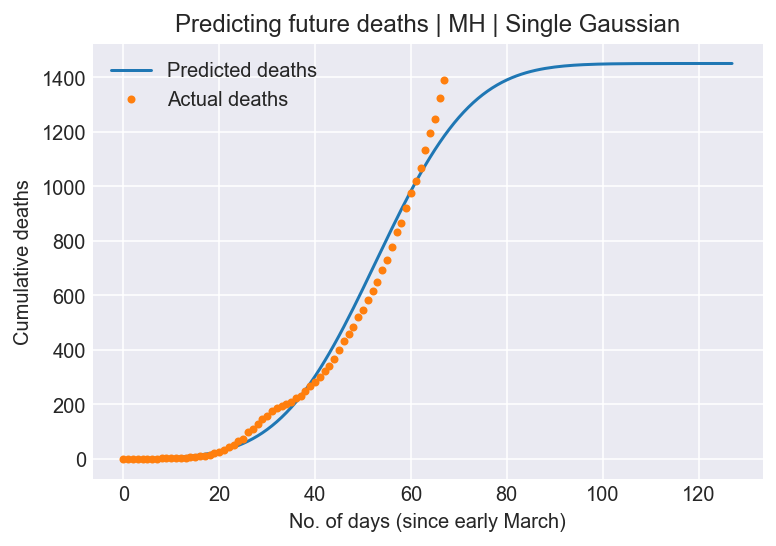

In [73]:
# Fit and plot data
death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF()
model_india.fit(death_data)
future_time_values = np.arange(death_data.shape[0] + extra_pred)
pred = model_india.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | MH | Single Gaussian")
plt.show()

<h2>MH - 13 gaussian atoms</h2>

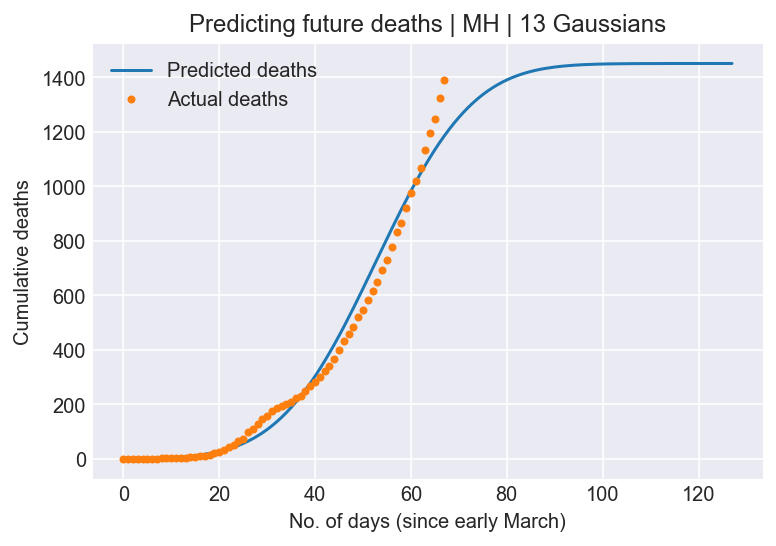

In [74]:
# Fit and plot data
params = model_india.get_params()
multi_gauss = MultiGaussianCDF(params)
ln_death_rate = np.log(np.cumsum(death_data) + 1)
multi_gauss.fit(ln_death_rate)

preds = multi_gauss.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | MH | 13 Gaussians")
plt.show()

<h1>Incorporating social distancing data</h1>



We still fit a Gaussian. However, we include a social distancing covariate for $\beta$

$$f(t; \alpha, \beta, p) =
        \frac{p}{2} \left( 1 + \frac{2}{\pi} \int_0^{\alpha ( t - \beta )}
            \exp( - \tau^2 ) d \tau \right)$$
            
Here, $f$ is the cumulative number of deaths and $\alpha, \beta, p$ are parameters with the following link functions

\begin{aligned}
    \alpha & = \exp( a + c_a \cdot s ) \\
    \beta  & =  b + c_b \cdot s \\
    p      & = \exp( \phi + c_\phi\cdot s )
\end{aligned}

where $a, b, \phi, c_a, c_b, c_\phi$ are fixed effects learnt by the model. $s$ is a social distancing covariate derived from Google's mobility data available publicly. The coefficients are chosen to be $1$ for now, but can be modified.

$$s = \Delta I_{r} + \Delta I_{g} + \Delta I_{p} + \Delta I_{t} + \Delta I_{w}$$

where each term corresponds to the percent change in mobility from baselines at different locations. These locations are

* $\Delta I_{r}$ - retail and recreation
* $\Delta I_{g}$ - grocery and pharmacy
* $\Delta I_{p}$ - parks 
* $\Delta I_{t}$ - transit stations
* $\Delta I_{w}$ - workplaces

In [75]:
def smoothen(X, std):
    result = np.zeros_like(X)
    
    for i, _ in enumerate(X):
        norm_factor = 0
        for j, _X in enumerate(X):
            val = norm.pdf(j, loc=i, scale=std)
            result[i] += _X * val
            norm_factor += val
        result[i] /= norm_factor
    
    return result

In [76]:
def get_social_distance(df, death_data):
    """Retrieve social distancing data from dataframe and resize"""

    df = deepcopy(df)
    
#     pdb.set_trace()
    
    # Make the lengths of the data equal
    if len(df) > len(death_data):
        df = df[:-(len(df) - len(death_data))]
    else:
        for i in range(len(death_data) - len(df)):
            df = df.append(df.iloc[-1])

    social_distance = np.zeros(len(df))
    for loc in locations:
        social_distance += np.array(df['{}_percent_change_from_baseline'.format(loc)])
    
    return smoothen(social_distance, 6)

<h3>India</h3>

In [77]:
# Get dataframe for the entire country from 25th Feb
# Although the death data starts from 14 March, we use mobilities from 25th Feb
# This is because the mean time to death is 18 days and so we shift the mobility data forward by 18 days 
df = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df = df[df['country_region'] == 'India']
df = df[pd.isnull(df['sub_region_1'])]
df = df[df['date'] >= '2020-02-25']
df.keys()

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

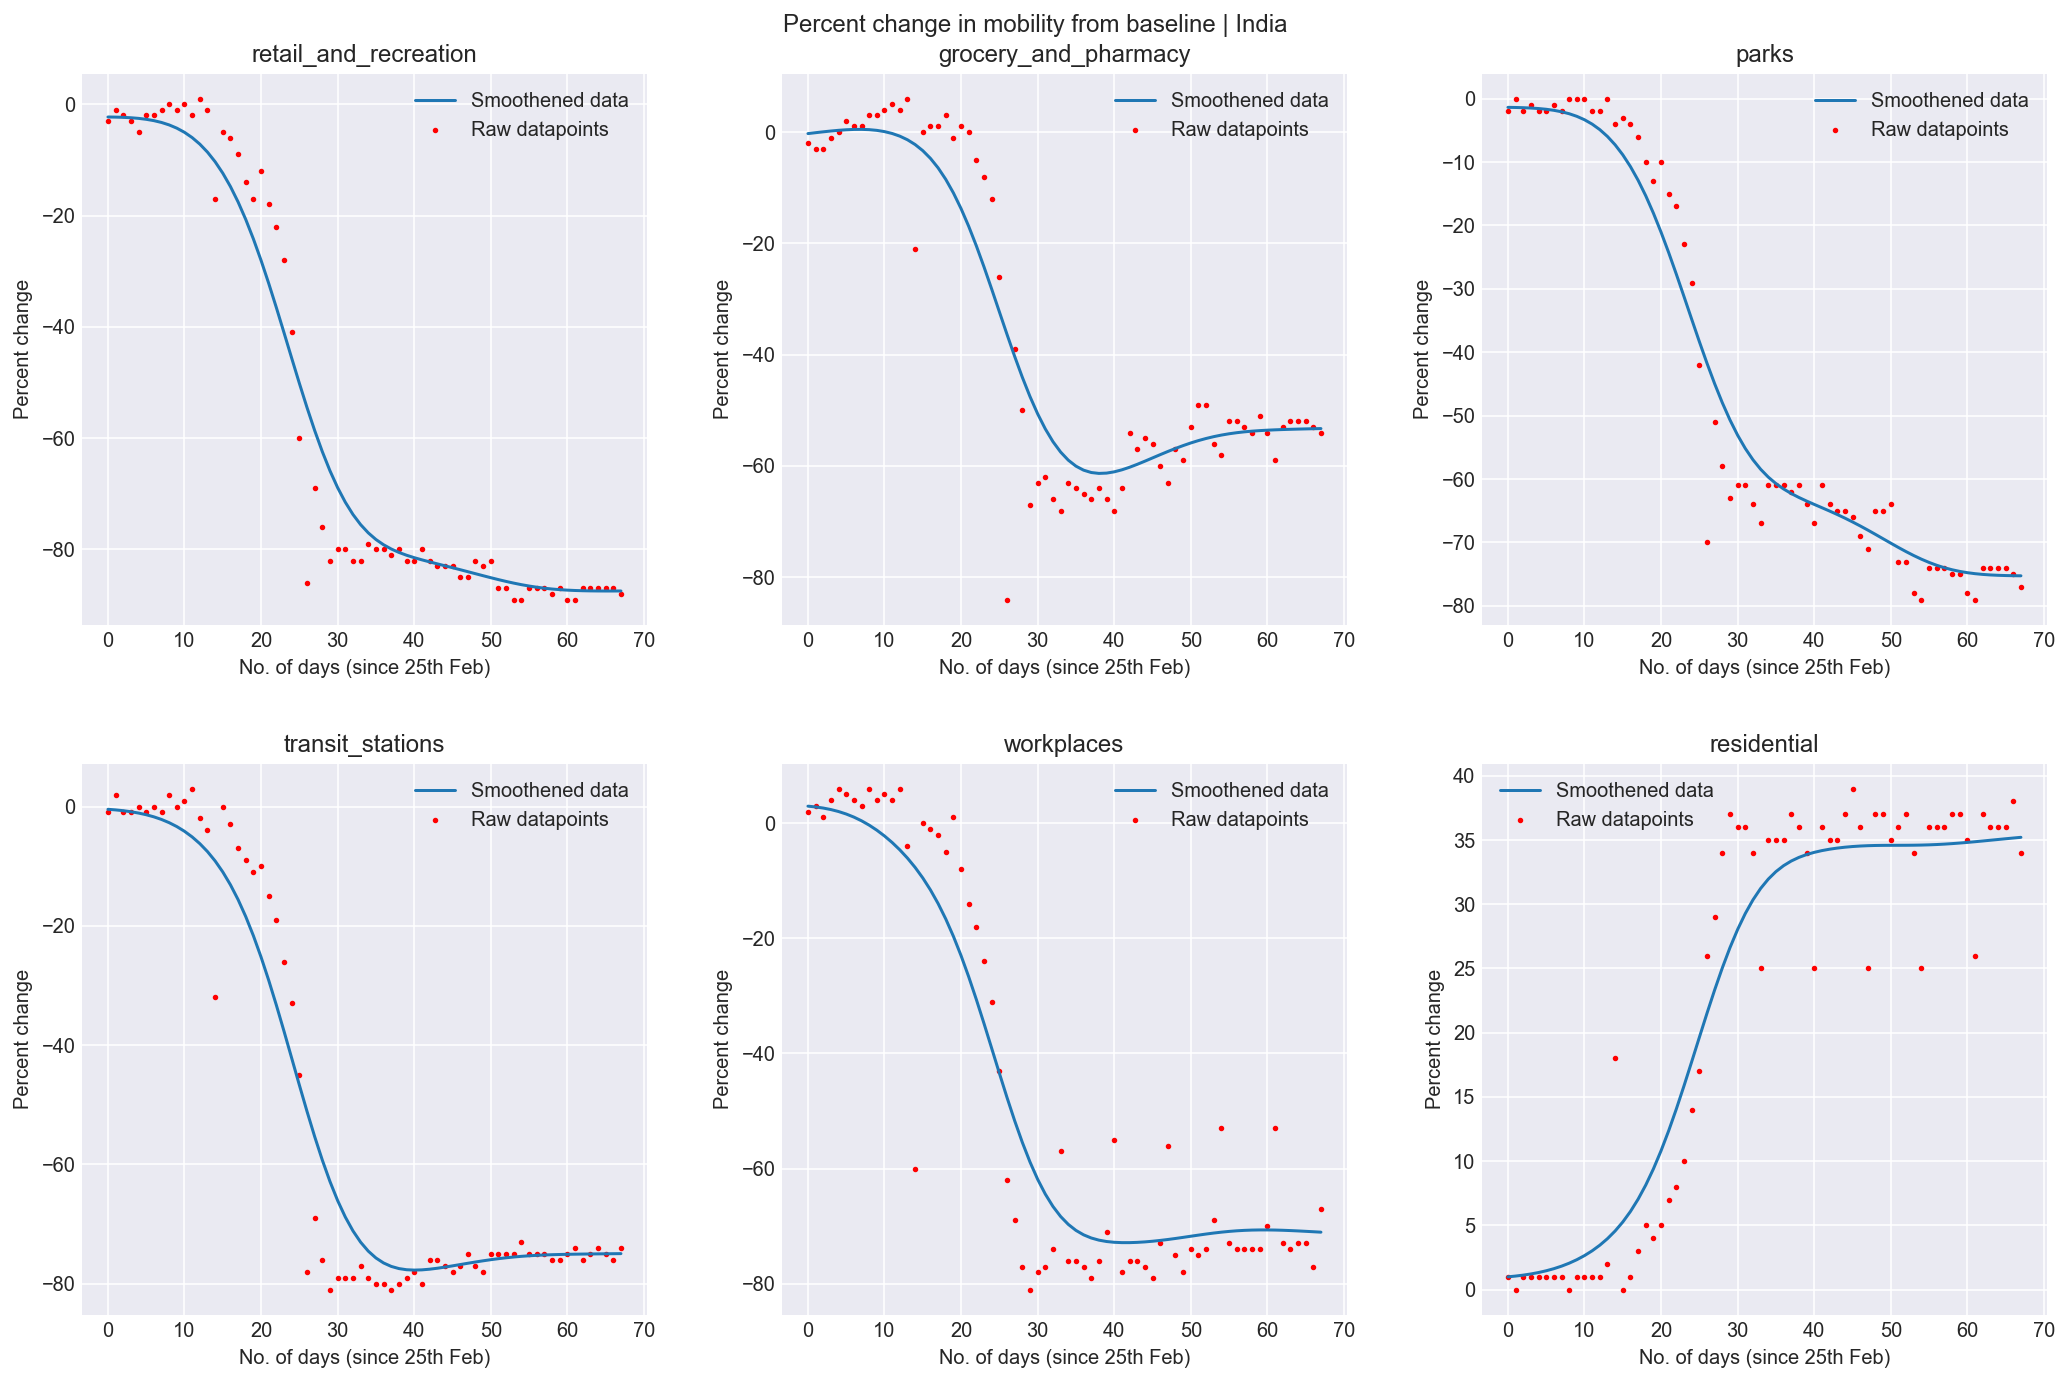

In [86]:
# Plot the data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

locations = ['retail_and_recreation',
             'grocery_and_pharmacy',
             'parks',
             'transit_stations',
             'workplaces',
             'residential']

for loc, ax in zip(locations, axs.flat):
    ydata = np.array(df['{}_percent_change_from_baseline'.format(loc)])
    xdata = range(len(ydata))
    ax.plot(xdata, smoothen(ydata, 6), label="Smoothened data")
    ax.scatter(xdata, ydata, label="Raw datapoints", s=3, c='red')
    ax.set_title("{}".format(loc))
    ax.set_xlabel("No. of days (since 25th Feb)")
    ax.set_ylabel("Percent change")
    ax.legend()
    
fig.suptitle("Percent change in mobility from baseline | India")
fig.tight_layout(pad=3.0)

In [79]:
# Fit and plot data
fetcher = DataFetcher()
fetcher.fetch()

# Exclude these days many days from the starting of the cases time series
offset = 43
death_data = fetcher.cases_time_series['dailydeceased'][offset:]

[2.37100007e-02 9.17670330e+01 1.67356399e+04]
[2.26164968e-02 9.73001245e+01 2.06306352e+04]
[1.63175808e-02 1.57142506e+02 1.98289084e+05]
[2.20933898e-02 9.98571858e+01 2.24544979e+04]
[2.05947991e-02 1.05763120e+02 2.46402688e+04]
[2.08237366e-02 1.04094580e+02 2.31155996e+04]


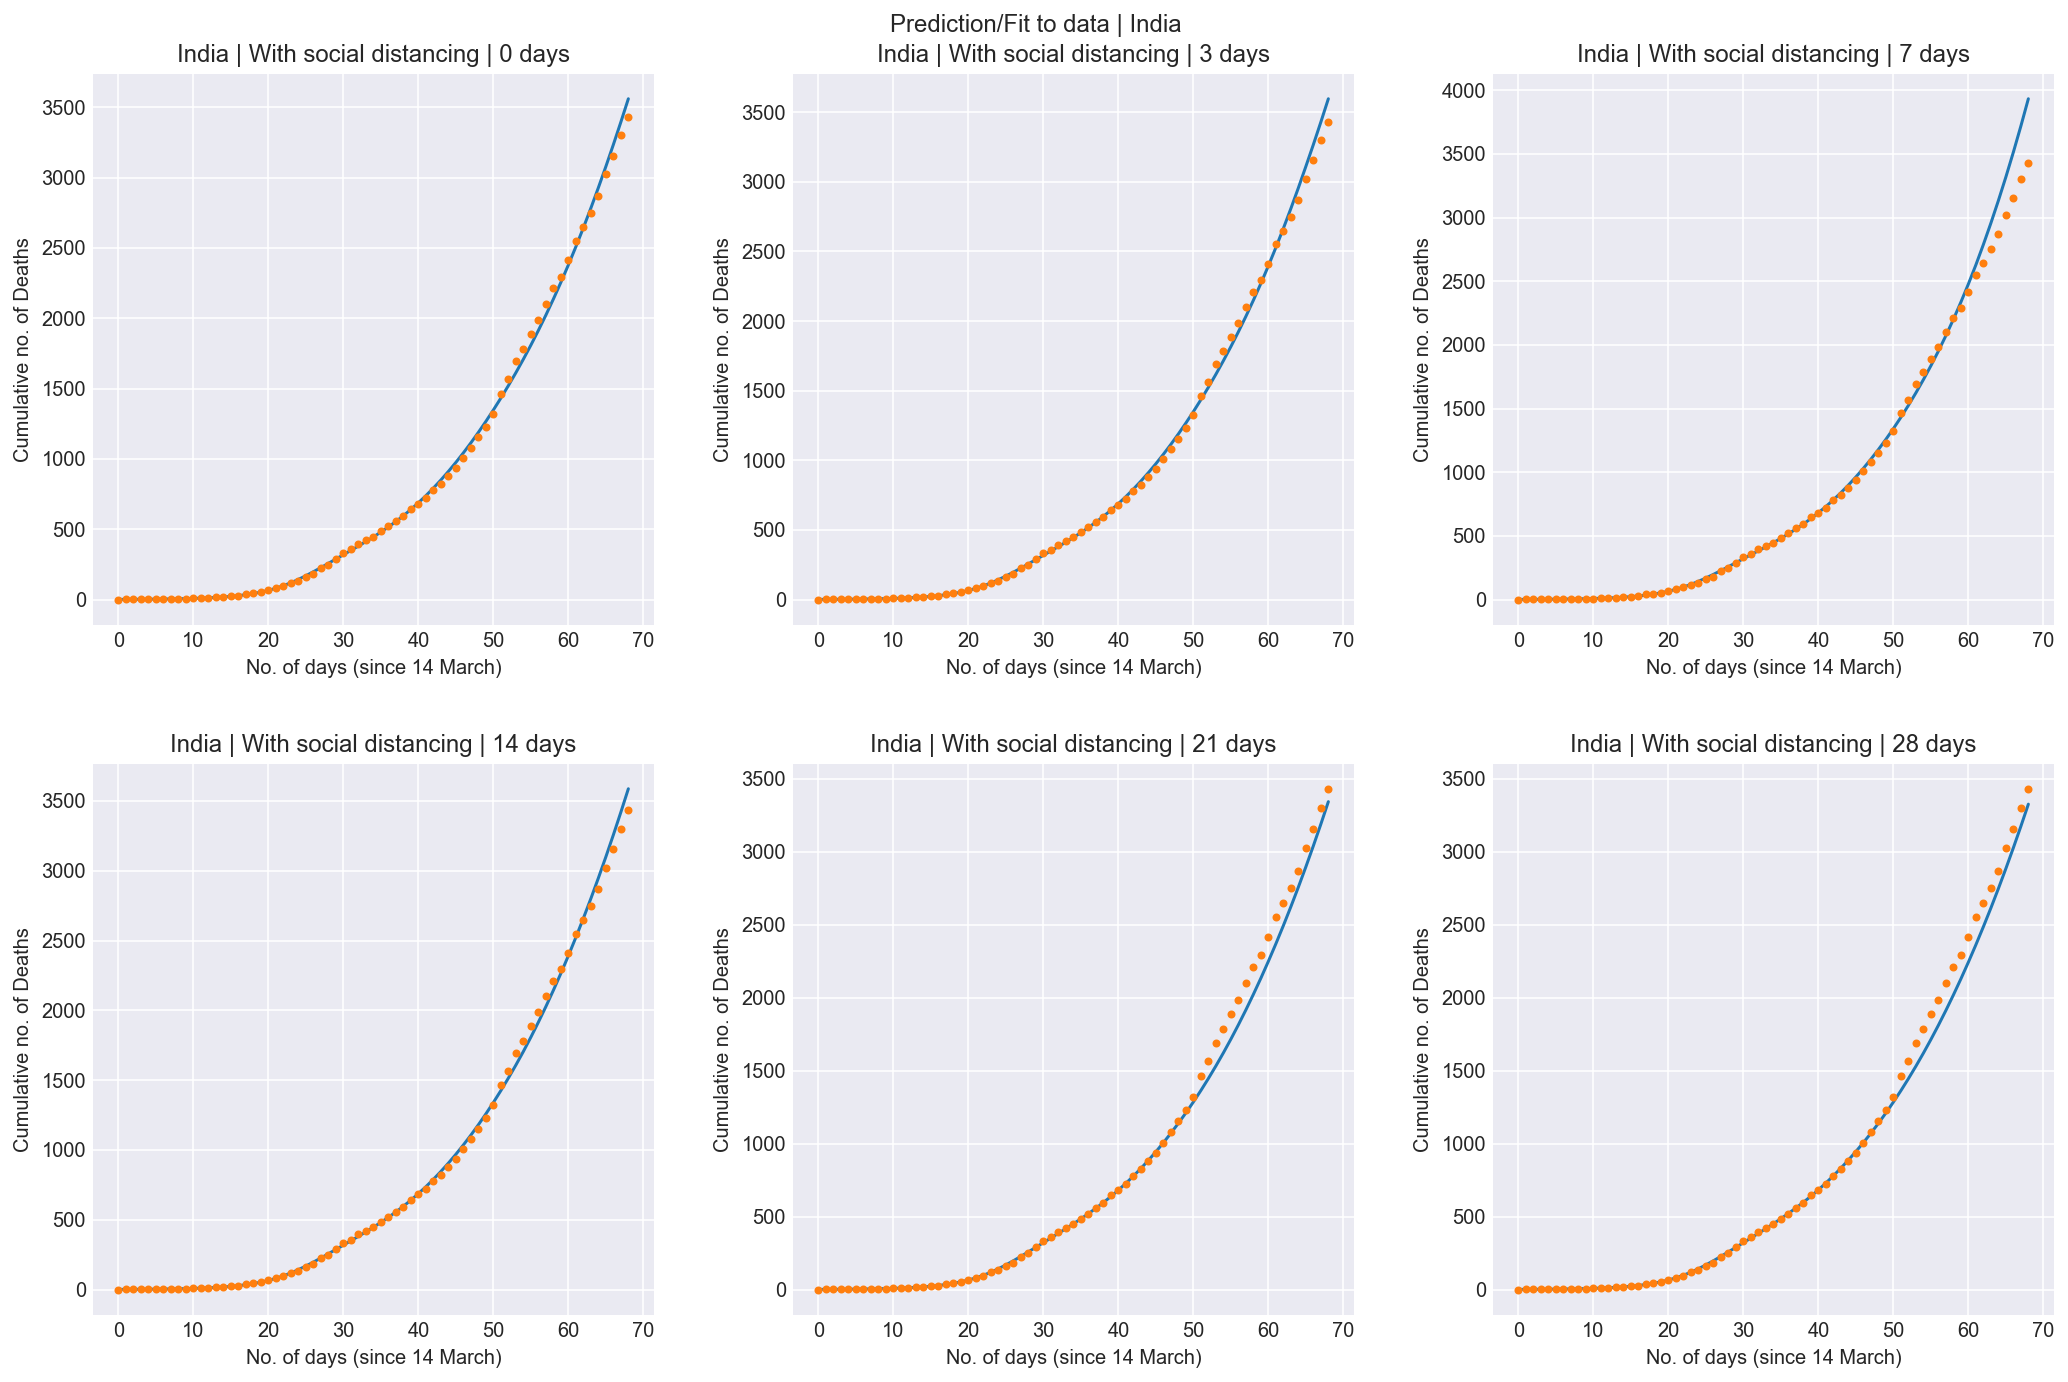

In [81]:
# Create plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

future_days = [0, 3, 7, 14, 21, 28]

for fut, ax in zip(future_days, axs.flat):
    s_death_data = death_data[:-fut] if fut != 0 else death_data
    social_distance = get_social_distance(df, s_death_data)
    
    # Fit and plot data
    np.random.seed(seed=123)
    model_india = GaussianCDF(social_distance)
    model_india.fit(s_death_data, fe_init=[-3, 0.00, 100, 0, 10.0, 0])
    
    print(model_india.get_params())
    
    time_values = np.arange(social_distance.shape[0] + fut)
    pred = model_india.predict_covar(time_values)
    
    ax.plot(time_values, np.exp(pred), label="Predicted deaths")
    ax.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
    ax.set_title("India | With social distancing | {} days".format(fut))
    ax.set_xlabel("No. of days (since 14 March)")
    ax.set_ylabel("Cumulative no. of Deaths")

fig.suptitle("Prediction/Fit to data | India")
fig.tight_layout(pad=3.0)

<h3>Maharashtra</h3>

In [82]:
# Get dataframe for the entire country from 25th Feb
# Although the death data starts from 14 March, we use mobilities from 25th Feb
# This is because the mean time to death is 18 days and so we shift the mobility data by 18 days forward
df = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df = df[df['country_region'] == 'India']
df = df[df['sub_region_1'] == 'Maharashtra']
df = df[df['date'] >= '2020-02-25']
df.keys()

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

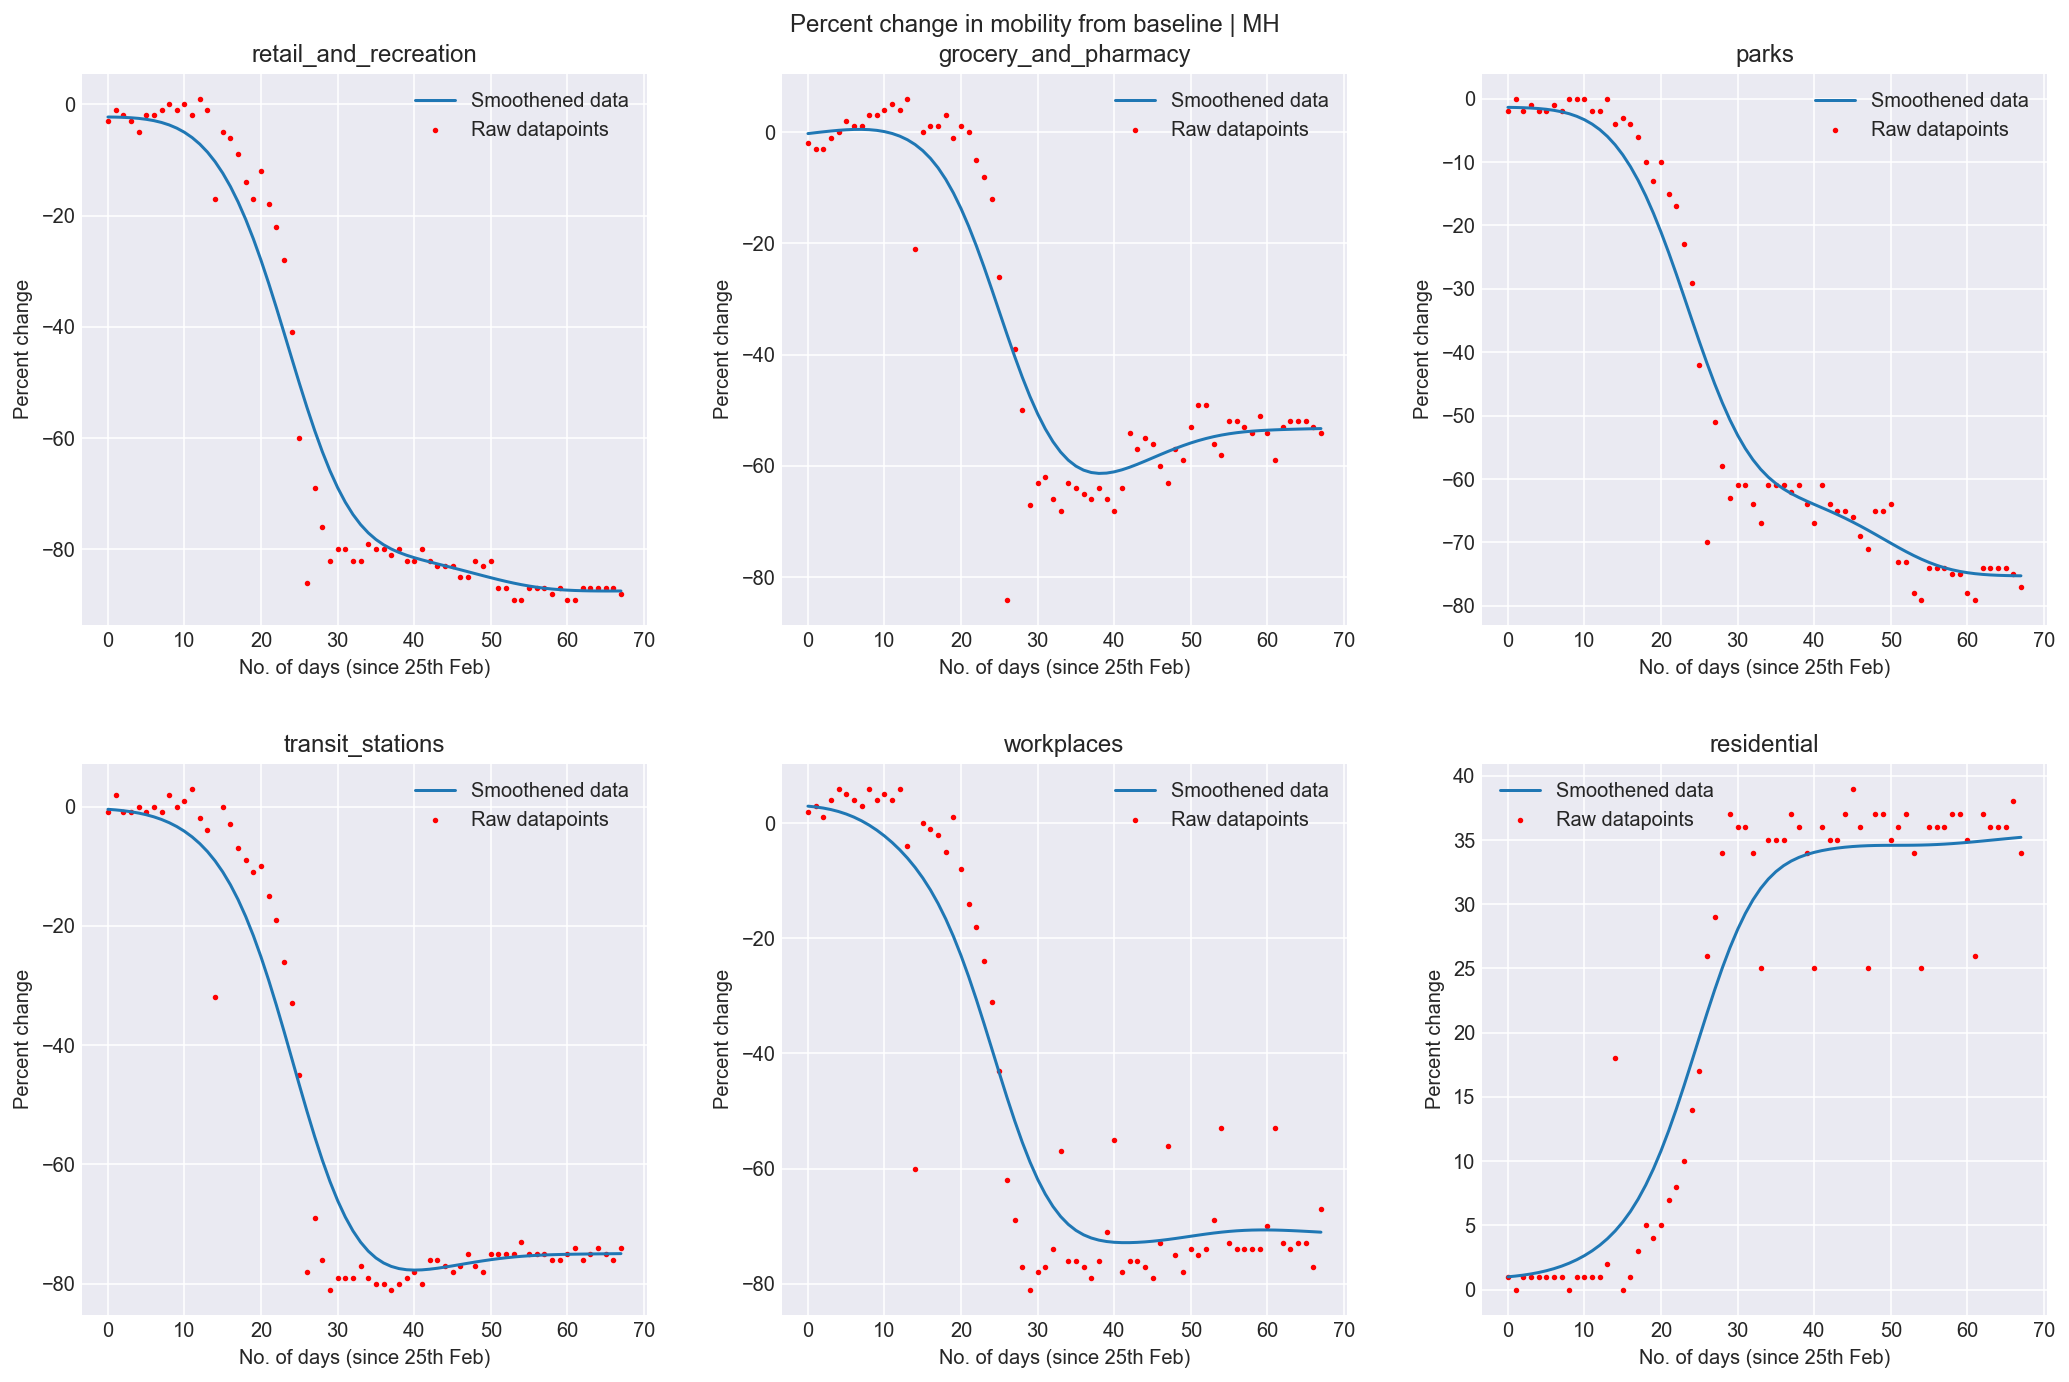

In [87]:
# Plot the data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

locations = ['retail_and_recreation',
             'grocery_and_pharmacy',
             'parks',
             'transit_stations',
             'workplaces',
             'residential']

for loc, ax in zip(locations, axs.flat):
    ydata = np.array(df['{}_percent_change_from_baseline'.format(loc)])
    xdata = range(len(ydata))
    ax.plot(xdata, smoothen(ydata, 6), label="Smoothened data")
    ax.scatter(xdata, ydata, label="Raw datapoints", s=3, c='red')
    ax.set_title("{}".format(loc))
    ax.set_xlabel("No. of days (since 25th Feb)")
    ax.set_ylabel("Percent change")
    ax.legend()
    
fig.suptitle("Percent change in mobility from baseline | MH")
fig.tight_layout(pad=3.0)

In [92]:
# Get the data
fetcher = DataFetcherState()
fetcher.fetch()

# Exclude these days many days from the starting of the cases time series
death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)

social_distance = get_social_distance(df, death_data)

[2.65734344e-02 7.63280733e+01 3.35202242e+03]


/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/curvefit/core/functions.py:283: RuntimeWarning: overflow encountered in multiply
  return 0.5 * np.sum(r * r)
/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/curvefit/core/functions.py:283: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.5 * np.sum(r * r)


[2.65734344e-02 7.63280733e+01 3.35202242e+03]
[2.65734344e-02 7.63280733e+01 3.35202242e+03]


/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/curvefit/core/functions.py:283: RuntimeWarning: overflow encountered in multiply
  return 0.5 * np.sum(r * r)
/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/curvefit/core/functions.py:283: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.5 * np.sum(r * r)


[2.65734344e-02 7.63280733e+01 3.35202242e+03]


/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/curvefit/core/functions.py:283: RuntimeWarning: overflow encountered in multiply
  return 0.5 * np.sum(r * r)
/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/curvefit/core/functions.py:283: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.5 * np.sum(r * r)


[2.65734344e-02 7.63280733e+01 3.35202242e+03]
[2.65734344e-02 7.63280733e+01 3.35202242e+03]


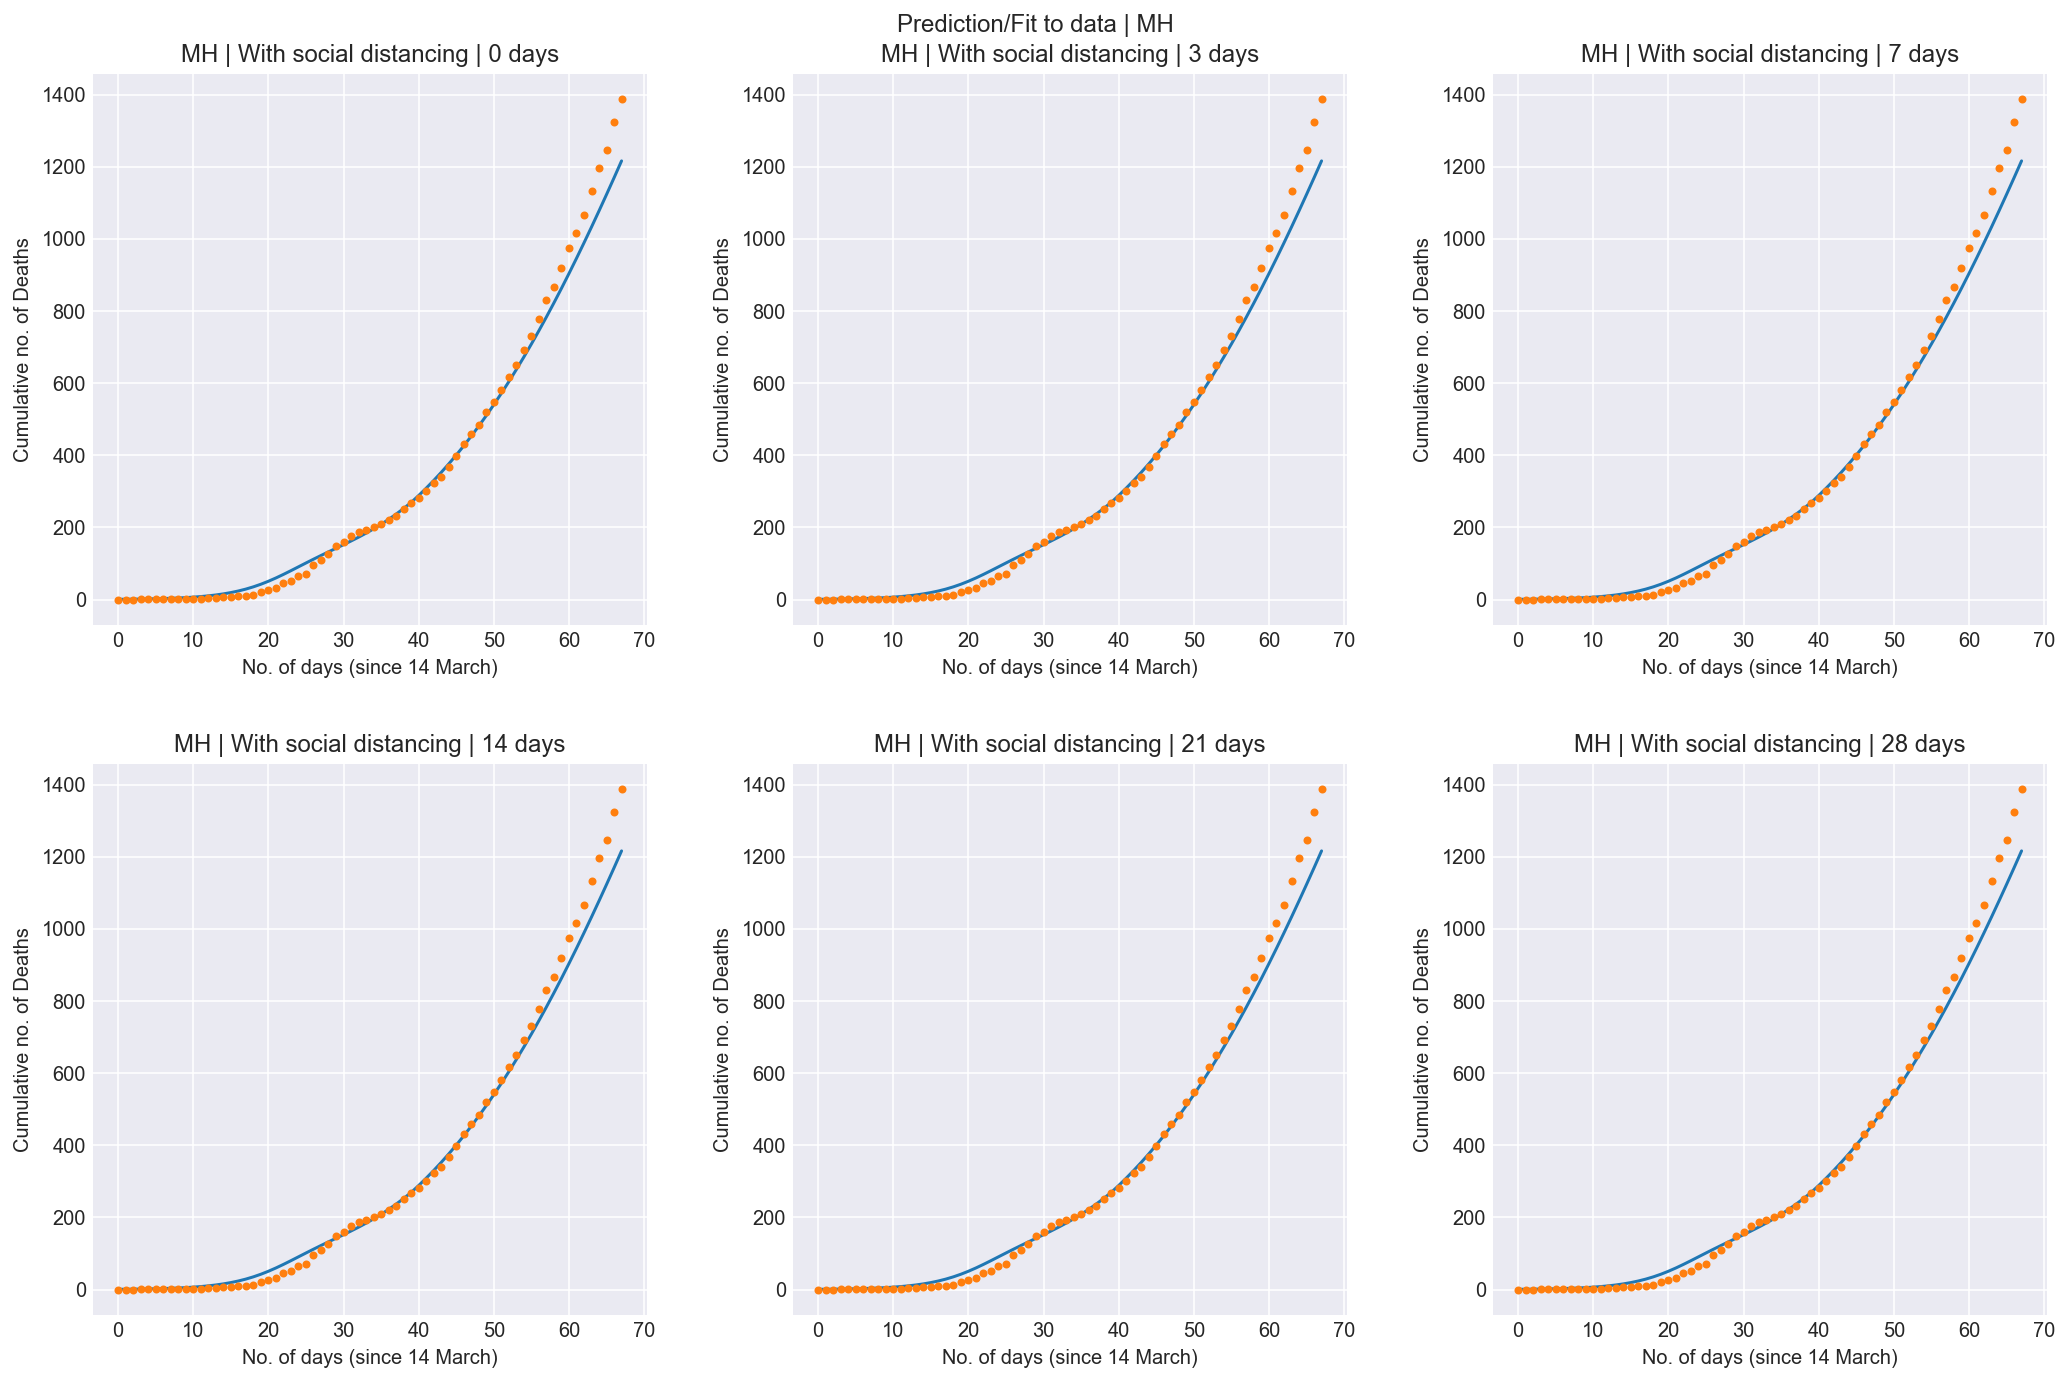

In [98]:
# Plot data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

future_days = [0, 3, 7, 14, 21, 28]

for fut, ax in zip(future_days, axs.flat):
    s_death_data = death_data[:-fut] if fut != 0 else death_data
    social_distance = get_social_distance(df, s_death_data)
    
    # Fit and plot data
    np.random.seed(seed=123)
    model_mh = GaussianCDF(social_distance)
    model_mh.fit(s_death_data, fe_init=[-3, 0.00, 100, 0, 10.0, 0])
    
    print(model_india.get_params())
    
    time_values = np.arange(social_distance.shape[0] + fut)
    pred = model_india.predict_covar(time_values)
    
    ax.plot(time_values, np.exp(pred), label="Predicted deaths")
    ax.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
    ax.set_title("MH | With social distancing | {} days".format(fut))
    ax.set_xlabel("No. of days (since 14 March)")
    ax.set_ylabel("Cumulative no. of Deaths")

fig.suptitle("Prediction/Fit to data | MH")
fig.tight_layout(pad=3.0)